In [1]:
## todo
# README.md : loss, activation, optimizer, initializer, Dense layer
# optimizer : learning rate scheduler, gradient clipping
# loss, activation : hyper parameter
# layer : cnn, rnn, dropout, batch normalization
# analysis : validation error
# fit : callbacks

# differentiation method -> How to obtain a stable numerical gradient
# tf -> custom calcuration program

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
def calcurate_gradient(function, data, epsilon):
    base = int(str(epsilon)[0])
    power = int(str(epsilon)[-1])

    epsilon_list = [float(f'{j}e-{i}') for i in range(power-1, power+1) for j in range(base, 10-base)]
    summed = 0

    for i in range(len(epsilon_list)-1):
        summed += function(data+epsilon_list[i]) - function(data+epsilon_list[i+1])

    return tf.cast(summed/len(epsilon_list), dtype=tf.float32)

In [4]:
class Section:
    def __init__(self, name, instance_map, **kwargs):
        self.name = name.lower()
        self.instance_map = instance_map
        
        if self.name not in self.instance_map:
            print(f"{self.__name__} : {self.name} is not exist")
            raise IndexError

        self.instance = self.instance_map[self.name](**kwargs)

    def set_instance(self, name, instance):
        if not issubclass(type(instance), self.Format):
            print(f"{instance.__name__} is not {type(self).__name__}")
            print(f"instance must inherit {type(self).__name__}.Format")
            raise TypeError

        self.instance = instance

In [5]:
class Activation(Section):
    def __init__(self, name='linear', **kwargs):
        instance_map = {'sigmoid' : Sigmoid, 'relu' : ReLU, 'linear' : Linear}
        super().__init__(name, instance_map, **kwargs)
        self.epsilon = kwargs.get('learning_rate', 1e-7)

    def calcurate(self, data):
        return self.instance.calcurate(data)

    def differentiate(self, data):
        return calcurate_gradient(self.calcurate, data, self.epsilon)

    class Format:
        def __init__(self, **kwargs):
            pass

        def calcurate(self, data):
            print("method name must be <calcurate>")
            raise NotImplementedError

class Sigmoid(Activation.Format):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calcurate(self, data):
        return tf.math.divide(1, (1 + tf.math.pow(np.e, -data)))

class ReLU(Activation.Format):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calcurate(self, data):
        return tf.math.maximum(0, data)

class Linear(Activation.Format):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def calcurate(self, data):
        return data

In [6]:
class Loss(Section):
    def __init__(self, name, **kwargs):
        instance_map = {'mse' : MeanSquaredError, 'ce' : BinaryCrossEntropy}
        super().__init__(name, instance_map, **kwargs)
        self.epsilon = kwargs.get('learning_rate', 1e-7)

    def calcurate(self, data):
        return self.instance.calcurate(data)

    def differ_calcurate(self, data):
        return self.instance.calcurate((self.true, data))

    def differentiate(self, data):
        self.true = data[0]
        return calcurate_gradient(self.differ_calcurate, data[1], self.epsilon)

    class Format:
        def calcurate(self, data):
            print("method name must be <calcurate>")
            raise NotImplementedError

class MeanSquaredError(Loss.Format):
    def __init__(self, **kwargs):
        pass

    def calcurate(self, data):
        return tf.math.reduce_mean(tf.math.pow(data[0] - data[1], 2))

class BinaryCrossEntropy(Loss.Format):
    def __init__(self, **kwargs):
        self.epsilon = kwargs.get('epslion', 1e-9)

    def calcurate(self, data):
        return -tf.math.reduce_sum(data[0] * tf.math.log(data[1] + self.epsilon))

In [7]:
class Optimizer(Section):
    def __init__(self, name, **kwargs):
        instance_map = {'sgd' : SGD, 'rmsprop' : RMSprop, 'adagrad' : Adagrad, 'adam' : Adam}
        super().__init__(name, instance_map, **kwargs)

    def update(self, params, gradients):
        params = [list(param) for param in params]
        return self.instance.update(params, gradients)

    class Format:
        def update(self, params, gradients):
            print("method name must be <update>")
            raise NotImplementedError

class SGD(Optimizer.Format):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)

    def update(self, params, gradients):
        for i in range(len(params)):
            params[i] = self.learning_rate * gradients[i]

        return params

class Momentum(Optimizer.Format):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.decay_rate = kwargs.get('decay_rate', 0.9)
        self.accumulated = None

    def update(self, params, gradients):
        if self.accumulated is None:
            self.accumulated = [0] * len(params)

        for i in range(len(params)):
            self.accumulated[i] = self.decay_rate * self.accumulated[i] + (1 - self.decay_rate) * gradients[i]
            params[i] = self.learning_rate * self.accumulated[i]

        return params

class Adagrad(Optimizer.Format):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-3)
        self.epsilon = kwargs.get('epsilon', 1e-8)
        self.accumulated = None

    def update(self, params, gradients):
        if self.accumulated is None:
            self.accumulated = [0] * len(params)
        
        for i in range(len(params)):
            self.accumulated[i] += tf.math.pow(gradients[i], 2)
            params[i] = self.learning_rate * gradients[i] / (self.epsilon + tf.math.sqrt(self.accumulated[i]))

        return params

class RMSprop(Optimizer.Format):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.decay_rate = kwargs.get('decay_rate', 0.9)
        self.epsilon = kwargs.get('epsilon', 1e-8)
        self.accumulated = None

    def update(self, params, gradients):
        if self.accumulated is None:
            self.accumulated = [0] * len(params)

        for i in range(len(params)):
            self.accumulated[i] = self.decay_rate * self.accumulated[i] + (1 - self.decay_rate) * tf.math.pow(gradients[i], 2)
            params[i] = self.learning_rate * gradients[i] / (self.epsilon + tf.math.sqrt(self.accumulated[i]))

        return params

class Adam(Optimizer.Format):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-3)
        self.beta1 = kwargs.get('beta1', 0.9)
        self.beta2 = kwargs.get('beta2', 0.999)
        self.epsilon = kwargs.get('epsilon', 1e-8)

        self.m = None
        self.v = None
        self.t = 0

    def update(self, params, gradients):
        if self.m is None:
            self.m = [0] * len(params)
            self.v = [0] * len(params)
        
        self.t += 1
        for i in range(len(params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.math.pow(gradients[i], 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            params[i] -= self.learning_rate * m_hat / (self.epsilon + tf.math.sqrt(v_hat))
            
        return params

In [8]:
class Initializer(Section):
    def __init__(self, name, input_shape, output_shape, **kwargs):
        kwargs['input_shape'] = input_shape
        kwargs['output_shape'] = output_shape

        instance_map = {'xavier' : Xavier, 'he' : He, 'lecun' : Lecun}
        super().__init__(name, instance_map, **kwargs)
        self.weight_stddev = self.instance.weight_stddev

    class Foramt:
        def __init__(self, **kwargs):
            self.input_shape = kwargs['input_shape']
            self.output_shape = kwargs['output_shape']

class Xavier(Initializer.Foramt):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.weight_stddev = tf.math.sqrt(2 / (self.input_shape + self.output_shape))

class He(Initializer.Foramt):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.weight_stddev = tf.math.sqrt(2 / (self.input_shape))

class Lecun(Initializer.Foramt):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.weight_stddev = tf.math.sqrt(1 / (self.input_shape))

In [9]:
class Layer(Section):
    def __init__(self, name, **kwargs):
        instance_map = {'dense' : Dense}
        super().__init__(name, instance_map, **kwargs)

        self.clip_range = kwargs.get('clip_range', None)
        self.dropout_rate = kwargs.get('dropout', 0.0)

    def calcurate(self, data):
        return self.instance.calcurate(data)

    def backpropagate(self, gradient, inputs, outputs):
        return self.instance.backpropagate(gradient, inputs, outputs)

    def set_optimizer(self, optimizer):
        self.instance.optimizer = copy.deepcopy(optimizer)

    class Format:
        def __init__(self, input_shape, output_shape, initializer, activation, **kwargs):
            self.initializer = Initializer(initializer.lower(), input_shape, output_shape, **kwargs)
            self.activation = Activation(activation.lower(), **kwargs)
            self.shape = (input_shape, output_shape)
            self.optimizer = None

        def calcurate(self, data):
            print("method name must be <calcurate>")
            raise NotImplementedError

        def backpropagate(self, gradient, inputs, outputs):
            print("method name must be <backpropagate>")
            raise NotImplementedError

In [10]:
class Dense(Layer.Format):
    def __init__(self, input_shape, output_shape, initializer="he", activation="linear", **kwargs):
        super().__init__(input_shape, output_shape, initializer, activation, **kwargs)

        self.weight = tf.Variable(tf.random.normal(shape=self.shape, mean=0, stddev=self.initializer.weight_stddev, dtype=tf.float32))
        self.bias = tf.Variable(tf.random.normal(shape=(1, self.shape[-1]), mean=0, stddev=0.01, dtype=tf.float32))

    def calcurate(self, data):
        layer_output = tf.math.add(tf.matmul(data, self.weight), self.bias)
        activation_output = self.activation.calcurate(layer_output)
        return layer_output, activation_output

    def backpropagate(self, gradient, inputs, outputs):
        layer_gradient = tf.math.multiply(outputs, gradient)
        weight_gradient = tf.matmul(tf.transpose(inputs), layer_gradient)
        bias_gradient = tf.math.reduce_sum(layer_gradient, axis=0, keepdims=True)

        param = self.optimizer.update([self.weight, self.bias], [weight_gradient, bias_gradient])
        self.weight.assign(param[0])
        self.bias.assign(param[1])

        return tf.matmul(layer_gradient, tf.transpose(self.weight))

In [11]:
class Neural_network:
    def __init__(self):
        self.network = []

    def to_object(self, param, class_):
        if type(param) == str:
            return class_(param)
        elif type(param) == class_:
            return param
        else:
            print(f'{type(class_)} param invalid')
            return NotImplemented

    def compile(self, loss, optimizer):
        self.loss = self.to_object(loss, Loss)
        self.optimizer = self.to_object(optimizer, Optimizer)

        for layer in self.network:
            layer.set_optimizer(self.optimizer)

        self.network_depth = len(self.network)

    def predict(self, data):
        self.calcuration_graph = [data]

        for layer in self.network:
            hidden_data, data = layer.calcurate(data)
            self.calcuration_graph.append(hidden_data)

        return data

    def evaluate(self, x, y):
        loss = self.loss.calcurate((y, self.predict(x)))
        return loss

    def fit(self, x, y, batch_size, epochs, verbose):
        loss_graph = []

        data_num = x.shape[0]
        mini_batch_num = data_num//batch_size
        epoch_digits = len(str(epochs))

        for epoch in range(epochs):
            for batch in range(mini_batch_num):
                index = np.random.randint(data_num, size=batch_size)
                batch_x = x[index, :]
                batch_y = y[index, :]

                batch_p = self.predict(batch_x)
                true_pred_pair = (batch_y, batch_p)

                loss = self.loss.calcurate(true_pred_pair)
                gradient = self.loss.differentiate(true_pred_pair)
                for i in range(self.network_depth):
                    gradient = self.network[-i-1].backpropagate(gradient, self.calcuration_graph[-i-2], self.calcuration_graph[-i-1])

                if verbose == 2:
                    print(f"epoch: {epoch:0{epoch_digits}d}, batch: {batch}/{mini_batch_num} | loss: ", f'{loss:.4f}' if loss <= 0.0001 else f'{loss:.4e}')

            if verbose == 1:
                print(f"epoch: {epoch:0{epoch_digits}d} | loss: ", f'{loss:.4f}' if loss > 0.0001 else f'{loss:.4e}')

            loss_graph.append(loss)

        return np.array(loss_graph)

In [12]:
# Generate a simple dataset for regression
X = np.random.rand(10000, 1)  # 10000 samples, 1 feature
y = 2 * X + 1 + 0.1 * np.random.randn(10000, 1)  # Linear relationship with some noise

# Normalize the data to be between 0 and 1
X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))

X_normalized = X_normalized.astype(dtype=np.float32)
y_normalized = y_normalized.astype(dtype=np.float32)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

x_train, x_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]

# Print the shapes of the datasets
print("Training data shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print("\nTesting data shapes:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training data shapes:
x_train: (8000, 1)
y_train: (8000, 1)

Testing data shapes:
x_test: (2000, 1)
y_test: (2000, 1)


In [13]:
model = Neural_network()
model.network.append(Layer('dense', input_shape=1, output_shape=32, activation='relu'))
model.network.append(Layer('dense', input_shape=32, output_shape=1, activation='linear'))

optimizer = Optimizer('adam', learning_rate=1e-5)
model.compile('mse', optimizer)

2024-02-01 02:07:25.039603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 02:07:25.040497: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.evaluate(x_test, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0997976>

In [15]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1)

epoch: 000 | loss:  0.0875
epoch: 001 | loss:  0.0962
epoch: 002 | loss:  0.0669
epoch: 003 | loss:  0.0696
epoch: 004 | loss:  0.0786
epoch: 005 | loss:  0.0466
epoch: 006 | loss:  0.0465
epoch: 007 | loss:  0.0404
epoch: 008 | loss:  0.0345
epoch: 009 | loss:  0.0314
epoch: 010 | loss:  0.0258
epoch: 011 | loss:  0.0279
epoch: 012 | loss:  0.0175
epoch: 013 | loss:  0.0192
epoch: 014 | loss:  0.0220
epoch: 015 | loss:  0.0215
epoch: 016 | loss:  0.0166
epoch: 017 | loss:  0.0149
epoch: 018 | loss:  0.0166
epoch: 019 | loss:  0.0128
epoch: 020 | loss:  0.0109
epoch: 021 | loss:  0.0090
epoch: 022 | loss:  0.0115
epoch: 023 | loss:  0.0092
epoch: 024 | loss:  0.0076
epoch: 025 | loss:  0.0072
epoch: 026 | loss:  0.0067
epoch: 027 | loss:  0.0079
epoch: 028 | loss:  0.0069
epoch: 029 | loss:  0.0079
epoch: 030 | loss:  0.0049
epoch: 031 | loss:  0.0073
epoch: 032 | loss:  0.0075
epoch: 033 | loss:  0.0070
epoch: 034 | loss:  0.0070
epoch: 035 | loss:  0.0084
epoch: 036 | loss:  0.0075
e

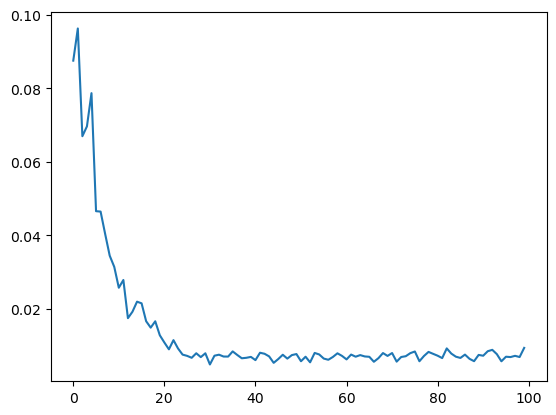

In [16]:
plt.plot(hist)
plt.show()

In [17]:
model.evaluate(x_test, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00696133>

make tensorflow model to compare

In [18]:
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Dense(32, activation='relu'))
tf_model.add(tf.keras.layers.Dense(1, activation='linear'))

tf_model.compile(loss='mse', optimizer='adam')

In [19]:
tf_model.evaluate(x_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.3608


0.36081621050834656

In [20]:
tf_hist = tf_model.fit(x_train, y_train, epochs=100, batch_size=256, verbose=1)

Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2316
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0661
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 12/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 13/100
32/32 [=================

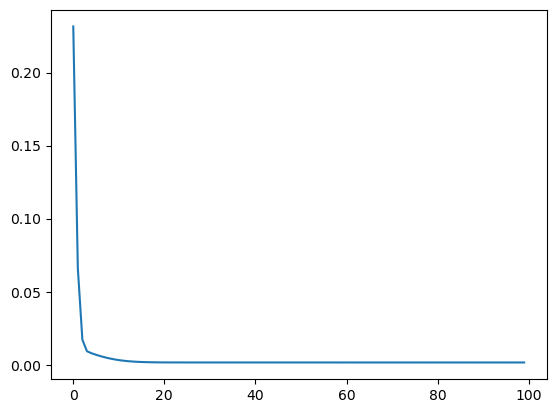

In [21]:
plt.plot(tf_hist.history['loss'])
plt.show()

In [22]:
tf_model.evaluate(x_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.0016


0.0015818014508113265